In [1]:
# Import Packages
import numpy as np
import pandas as pd
from scipy.optimize import minimize, LinearConstraint, Bounds
from pandas import read_csv
from datetime import datetime
import matplotlib.pyplot as plt

In [1]:
from nb2wp import nb2wp

help(nb2wp)

Help on module nb2wp.nb2wp in nb2wp:

NAME
    nb2wp.nb2wp - # -*- coding: utf-8 -*-

FUNCTIONS
    nb2wp(nbfile, out_dir='', template='full', css_files=['style.css'], save_img=True, img_dir='img', img_url_prefix='img', latex='wp', remove_attrs=True, footer=True, save_css=False, save_html=False, quiet=False)
        Convert Jupyter notebook file to Wordpress.com HTML.
        
        Parameters:
        nbfile:     The Jupyter notebook file
        out_dir:    Specify output directory. If empty,  a directory  with the same
                    name as the notebook file will be created.
        template:   (Optional) nbconvert template file. The default is "full".  You
                    may specify standard nbconvert template names such as "full" or
                    "basic", or the path of custom nbconvert .TPL file.
        css_files:  Specify list of CSS files  to use.  The files will be  appended
                    after one another. Default is  ['style.css'].  If not specified

In [7]:
def processDatetimes(csv_file):
    
    # read in the csv file
    data = pd.read_csv(csv_file)
    
    # convert Unix time format from TradingView to datetime objects
    dateTimes = []
    for unixTime in data['time']:
        dateTimes.append(datetime.strptime(datetime.fromtimestamp(unixTime).strftime('%Y-%m-%d %H:%M:%S'),'%Y-%m-%d %H:%M:%S')) 
    
    # assigns the datetimes as the index for the dataframe and drop it from your Pandas columns
    data.index = dateTimes
    data = data.drop(['time'],axis=1)
    data = data.dropna()
        
    return data

In [8]:
def CreatelistofIndices(data, trainingPeriod, testPeriod):
    
    # assign the index location that you want to start at
    first_row = 200
    last_row  = first_row + trainingPeriod + testPeriod
    
    # creates a list data structure, where each entry in the list is a list of indices
    listofIndices = []
    while last_row < data.shape[0]+1:
        listofIndices.append(data.iloc[first_row:last_row].index)
        first_row += testPeriod # include this row if you want to do a rolling analysis. Remove this line of code if you want to do an anchored analysis
        last_row  += testPeriod
        
    return listofIndices

In [10]:
def optimizeWeights(data):

    def index_volatility(weights, data):

        index = weights[0]*data['EURUSD'] + weights[1]*data['EURCHF'] + weights[2]*data['EURCAD'] + weights[3]*data['EURAUD'] + weights[4]*data['EURGBP'] + weights[5]*data['EURJPY']
    
        return index.std()
    
    
    bounds = Bounds(np.zeros(6),np.ones(6))
    con = ({'type': 'eq', 'fun': lambda weights:  1 - sum(weights)})
    
    weight_EURUSD = 0.2
    weight_EURCHF = 0.2
    weight_EURCAD = 0.2
    weight_EURAUD = 0.2
    weight_EURGBP = 0.2
    weight_EURJPY = 0.2

    weights = np.array([0.2,0.2,0.2,0.2,0.2,0.2])

    results = minimize(index_volatility, args = (data), x0=weights, constraints=con, bounds=bounds)
    
    weight_EURUSD,weight_EURCHF,weight_EURCAD,weight_EURAUD,weight_EURGBP,weight_EURJPY = results['x']
    
    return weight_EURUSD,weight_EURCHF,weight_EURCAD,weight_EURAUD,weight_EURGBP,weight_EURJPY

# EUR

<ipython-input-48-76db4a72049a>:13: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  backtestProfits = pd.Series()
<ipython-input-48-76db4a72049a>:14: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  backtestReturns = pd.Series()
<ipython-input-48-76db4a72049a>:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  backtestSignals = pd.Series()


<AxesSubplot:>

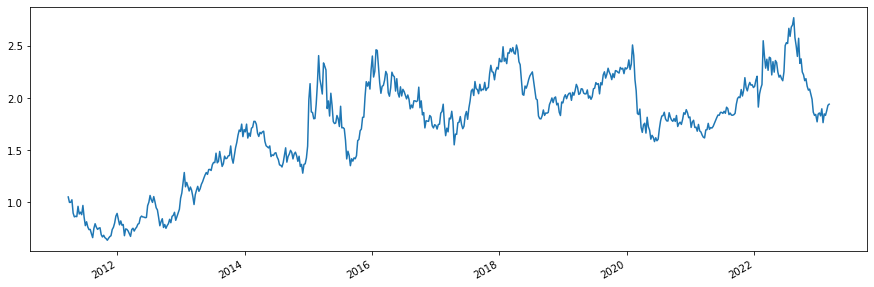

In [48]:
data = processDatetimes('OANDA_EURUSD, 1W_594d3.csv')

for currency in data.drop(['USD_LT','EUR_LT','GBP_LT','JPY_LT','CAD_LT','AUD_LT','CHF_LT','OIL_LT'],axis=1).columns:
    data[currency] = (data[currency].shift(-1)-data[currency]) / data[currency]

data['LT'] = data['EUR_LT']

trainPeriod = 52*3
testPeriod = 26

indicestoTest = listofIndices(data, trainPeriod, testPeriod)

backtestProfits = pd.Series()
backtestReturns = pd.Series()
backtestSignals = pd.Series()

optimal_LT1s = []

weight_EURUSD = 0.2
weight_EURCHF = 0.2
weight_EURCAD = 0.2
weight_EURAUD = 0.2
weight_EURGBP = 0.2
weight_EURJPY = 0.2

for indices in indicestoTest:
    
    LT1s = []
    trainProfits = []
    
    #weight_EURUSD,weight_EURCHF,weight_EURCAD,weight_EURAUD,weight_EURGBP,weight_EURJPY = optimizeWeights(data.loc[indices].iloc[:-testPeriod])
    data['return'] = weight_EURUSD*data['EURUSD'] + weight_EURCHF*data['EURCHF'] + weight_EURCAD*data['EURCAD'] + weight_EURAUD*data['EURAUD'] + weight_EURGBP*data['EURGBP'] + weight_EURJPY*data['EURJPY']
        
    for LT1 in range(5,50,5):
            
        trainData = data
        
        trainData['LT signal 1'] = np.where((trainData['return']+1).cumprod().shift(1) - (trainData['return']+1).cumprod().shift(LT1) > 0, 1, -1)
        #trainData['LT signal 1'] = np.where(trainData['LT']-trainData['LT'].shift(LT1) > 0, 1, -1)
        trainData['signal'] = trainData['LT signal 1']
            
        trainData = trainData.loc[indices].iloc[:-testPeriod]
            
        profits = (trainData['signal']*trainData['return']+1)
        cumulativeProfit = profits.cumprod()[-2]
        volatility = profits.std()*np.sqrt(profits.shape[0])
        sharpe = cumulativeProfit/volatility
        
        LT1s.append(LT1)
        trainProfits.append(sharpe)
        
    results = pd.DataFrame()
    results['LT1s'] = LT1s
    results['train profits'] = trainProfits

    LT1_optimal = results[results['train profits']==results['train profits'].max()]['LT1s'].iloc[0]
    
    ### Test Section
    
    testData = data
    
    testData['LT signal 1'] = np.where((testData['return']+1).cumprod().shift(1) - (testData['return']+1).cumprod().shift(LT1) > 0, 1, -1)
    #testData['LT signal 1'] = np.where(testData['LT']-testData['LT'].shift(LT1_optimal) > 0, 1, -1)
    testData['signal'] = testData['LT signal 1']
    
    if results['train profits'].max() < 1:
        testData['signal'] = testData['signal']*0
    
    testData = testData.loc[indices].iloc[-testPeriod:]
        
    testProfits = testData['signal']*testData['return']
    
    backtestProfits = backtestProfits.append(testProfits)
    backtestReturns = backtestReturns.append(testData['return'])
    backtestSignals = backtestSignals.append(testData['signal'])
    
    optimal_LT1s.append(LT1_optimal)
    
plt.rcParams["figure.figsize"] = (15,5)

backtestResults = (backtestProfits*50*0.1+1).cumprod()

backtestResults.plot()
#np.log(backtestProfits*50*0.1+1).cumsum().plot()

<AxesSubplot:>

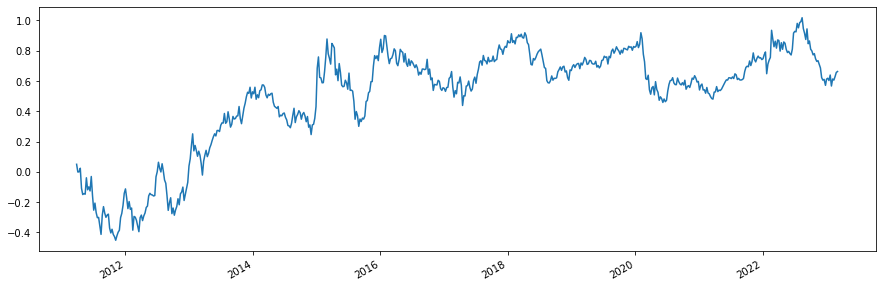

In [49]:
np.log(backtestProfits*50*0.1+1).cumsum().plot()

In [50]:
drawdowns = []
past_percents = []
    
returns_percent = backtestResults.dropna()

#np.log(optimized_weights*50*0.1+1).cumsum().plot()
#np.log(backtestProfits*50*0.1+1).cumsum().plot()
    
for cum_percent in returns_percent:
    past_percents.append(cum_percent)
    draw = min(0,(cum_percent - max(past_percents))/max(past_percents))
    drawdowns.append(draw)
    
max_drawdown = abs(min(drawdowns))*100
annual_return = (returns_percent.iloc[-1]**(52/returns_percent.shape[0]) - 1)*100
win_rate = backtestProfits[backtestProfits > 0].shape[0] / backtestProfits.shape[0]*100
average_wins = (backtestProfits[backtestProfits > 0]).mean()*100
average_loss = (backtestProfits[backtestProfits < 0]).mean()*100
volatility = (backtestProfits).std()*100
sharpe =  (annual_return-4) / (volatility*np.sqrt(52))
    
print('       max drawdown: ' + str(round(max_drawdown,2))+'%')
print('      annual return: ' + str(round(annual_return,2))+'%')
print('           win rate: ' + str(round(win_rate,2))+'%')
print('average winning day: ' + str(round(average_wins,2))+'%')
print(' average losing day: ' + str(round(average_loss,2))+'%')
print('       sharpe ratio: ' + str(round(sharpe,2)))

       max drawdown: 43.84%
      annual return: 5.68%
           win rate: 52.24%
average winning day: 0.71%
 average losing day: -0.69%
       sharpe ratio: 0.25


In [3]:
nb2wp.nb2wp('Low_Volatility.ipynb')

Using template: full


TemplateNotFound: full